In [11]:
# pip install yfinance finvizfinance transformers pandas numpy statsmodels holidays plotly ipywidgets

In [7]:

import yfinance as yf
from finvizfinance.quote import finvizfinance
from transformers import pipeline
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import holidays
import plotly.graph_objects as go
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import seaborn as sns 





## What do Large Language Models do?

Large language models like ChatGPT do something that seems very simple: **Next word prediction.**

What does that mean? It means that given a sequence of words, the model predicts the next word in the sequence. For example, if the input is "The cat sat on the", the model might predict "mat" as the next word.


```{mermaid}
flowchart LR
    THE["the"]
    CAT["cat"]
    SAT["sat"]
    ON["on"]
    MAT["mat"]
    MODEL["LLM"]

    THE --> CAT --> SAT --> ON --> MODEL --> MAT

    style MAT fill:#FFD700,stroke:#333,stroke-width:2px,font-weight:bold
    style MODEL fill:#ADD8E6,stroke:#333,stroke-width:2px
```

We saw an example of predicting just one word. These models predict only one word at a time, but they can do this for very long sequences of words.

For example: "bob went to the store" to buy some milk.

```{mermaid}
flowchart TB

  subgraph S1["bob went to"]
    direction LR
    B1[bob] --> W1[went] --> T1[to] --> M1[LLM] --> P1[buy]
    style M1 fill:#ADD8E6,stroke:#333,stroke-width:2px
    style P1 fill:#FFD700,stroke:#333,stroke-width:2px,font-weight:bold
  end

  subgraph S2["bob went to buy"]
    direction LR
    B2[bob] --> W2[went] --> T2[to] --> B2b[buy] --> M2[LLM] --> P2[some]
    style M2 fill:#ADD8E6,stroke:#333,stroke-width:2px
    style P2 fill:#FFD700,stroke:#333,stroke-width:2px,font-weight:bold
  end

  subgraph S3["bob went to buy some"]
    direction LR
    B3[bob] --> W3[went] --> T3[to] --> B3b[buy] --> S3b[some] --> M3[LLM] --> P3[milk]
    style M3 fill:#ADD8E6,stroke:#333,stroke-width:2px
    style P3 fill:#FFD700,stroke:#333,stroke-width:2px,font-weight:bold
  end

  %% Connect subgraphs to stack vertically
  S1 --> S2
  S2 --> S3

  style S1 fill:none,stroke:none
  style S2 fill:none,stroke:none
  style S3 fill:none,stroke:none
```

What the model is doing is learning the probability distribution of the next word given the previous words.

The probability of predicting the next word $w_{t}$ given the previous words $w_1, w_2, \ldots, w_{t-1}$ is:

$$
P(w_t \mid w_1, w_2, \ldots, w_{t-1}) = \frac{P(w_1, w_2, \ldots, w_{t-1}, w_t)}{P(w_1, w_2, \ldots, w_{t-1})}
$$

LLMs approximate this probability:

$$
P(w_t \mid w_1, w_2, \ldots, w_{t-1})
$$

The model predicts the next word by selecting the word $w_t$ that maximizes this conditional probability:

$$
\hat{w}_t = \arg\max_{w} P(w \mid w_1, w_2, \ldots, w_{t-1})
$$

These models give a probability distribution over the entire vocabulary (all the words the model was trained on). We can then pick the word with the highest probability as the next word or we can sample from this distribution to get more varied (creative) outputs.

Lets look at an example of how this works in practice:

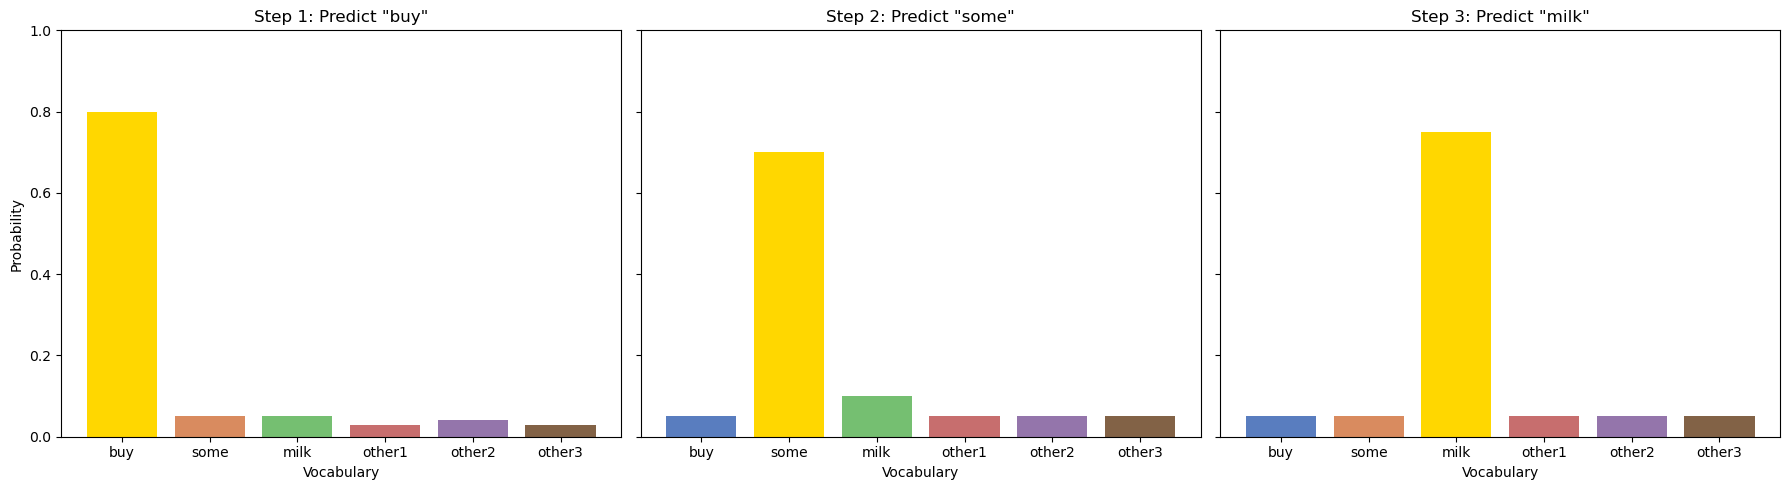

In [8]:
#| echo: false
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

# Example vocabulary
vocab = ['buy', 'some', 'milk', 'other1', 'other2', 'other3']

# Probabilities at each step (toy example)
probs_step1 = [0.8, 0.05, 0.05, 0.03, 0.04, 0.03]  # 'buy' high
probs_step2 = [0.05, 0.7, 0.1, 0.05, 0.05, 0.05]   # 'some' high
probs_step3 = [0.05, 0.05, 0.75, 0.05, 0.05, 0.05] # 'milk' high

prob_distributions = [probs_step1, probs_step2, probs_step3]
step_labels = ['Step 1: Predict "buy"', 'Step 2: Predict "some"', 'Step 3: Predict "milk"']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, ax in enumerate(axes):
    sns.barplot(x=vocab, y=prob_distributions[i], palette='muted', ax=ax)
    ax.set_title(step_labels[i])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability' if i == 0 else '')
    ax.set_xlabel('Vocabulary')
    # Highlight the max prob bar in gold
    max_idx = prob_distributions[i].index(max(prob_distributions[i]))
    ax.bar(max_idx, prob_distributions[i][max_idx], color='gold')

plt.tight_layout()
plt.show()

To get more creative responses you change the distribution at the output where you pick the next word. Very simply this involves making the distribution sharper or flatter.
If you make the distribution sharper, you are more likely to pick the word with the highest probability. If you make it flatter, you are more likely to pick a word that is not the most probable one.

This is called **temperature**. A higher temperature makes the distribution flatter, while a lower temperature makes it sharper. You would want to use a temperature of more than 1 $(1.2-1.5)$ for creative responses, and a temperature of less than 1 $(0.1 - 0.5)$ for more focused responses. For a balanced response, you can use a temperature of $0.7-1$.
Another set of parameters are called top-p and top-k sampling.

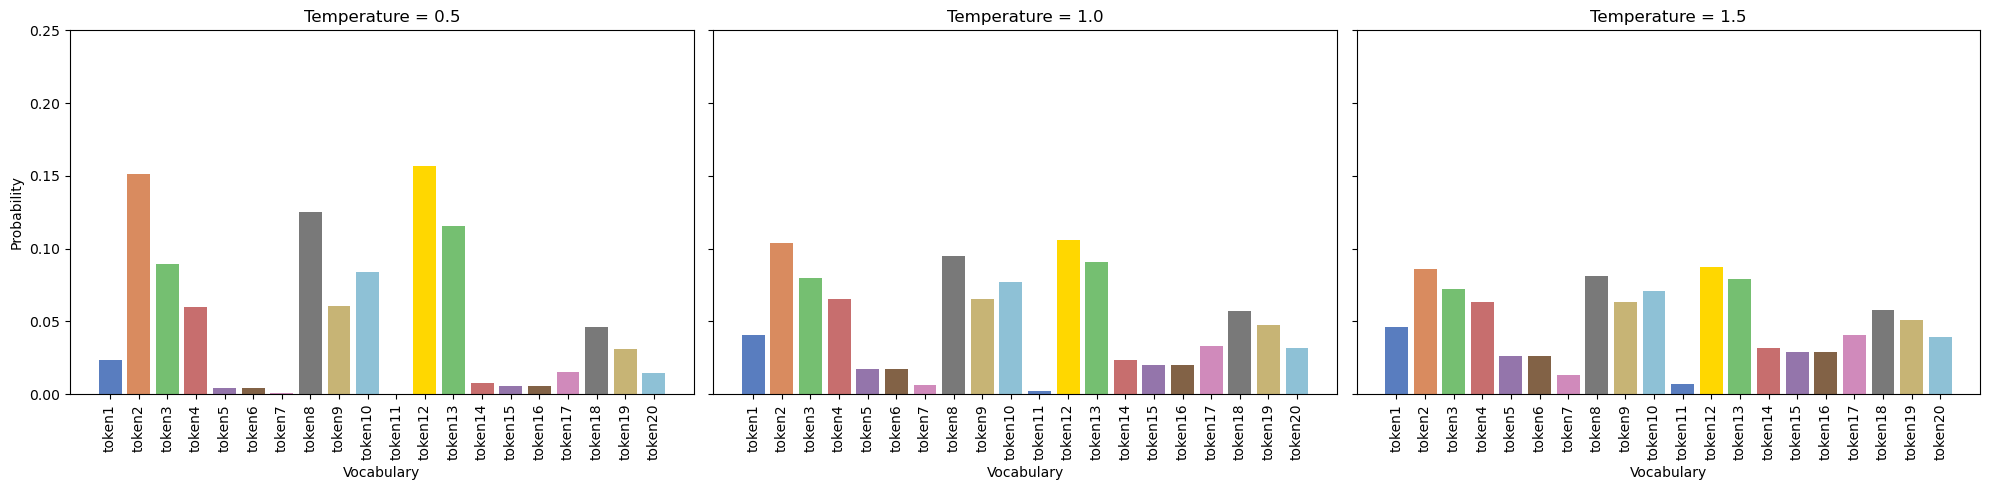

In [9]:
#| echo: false
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
vocab_size = 20
vocab = [f'token{i}' for i in range(1, vocab_size+1)]
base_probs = np.random.rand(vocab_size)
base_probs /= base_probs.sum()  # Normalize to sum to 1

def apply_temperature(probs, temp):
    logits = np.log(probs + 1e-20)
    scaled_logits = logits / temp
    exp_logits = np.exp(scaled_logits)
    return exp_logits / exp_logits.sum()

temperatures = [0.5, 1.0, 1.5]
distributions = [apply_temperature(base_probs, t) for t in temperatures]

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
for i, (ax, dist, temp) in enumerate(zip(axes, distributions, temperatures)):
    sns.barplot(x=vocab, y=dist, palette='muted', ax=ax)
    ax.set_title(f'Temperature = {temp}')
    ax.set_ylim(0, 0.25)
    ax.set_ylabel('Probability' if i == 0 else '')
    ax.set_xlabel('Vocabulary')
    ax.tick_params(axis='x', rotation=90) # Rotate x-axis labels
    max_idx = dist.argmax()
    ax.bar(max_idx, dist[max_idx], color='gold')

plt.tight_layout()
plt.show()

In the example above, we see how the probability distribution changes with different temperatures. A high temperature (1.5) results in a flatter distribution, meaning the model is more likely to sample from less probable tokens, while a low temperature (0.5) results in a sharper distribution, favoring the most probable tokens.

Note that while this is with words and language, the same idea applies to any sequential data, like stock prices, weather data, etc. The model learns the probability distribution of the next value given the previous values.

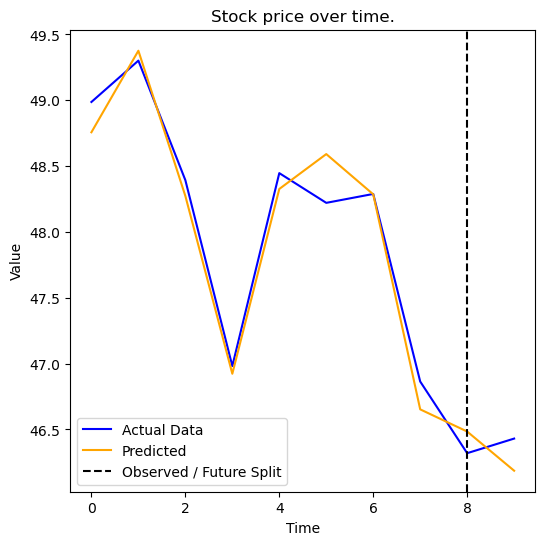

In [10]:
#| echo: false

import numpy as np
import matplotlib.pyplot as plt

n = 10
m = 9

# Generate actual data: random walk + small trend
actual_data = np.cumsum(np.random.normal(0, 1, n)) + 50

# Predictor approximates entire data closely with small noise everywhere
predicted = actual_data + np.random.normal(0, 0.2, n)

# Posterior uncertainty: low and roughly constant over entire period
posterior_std = np.full(n, 0.3)

upper = predicted + posterior_std
lower = predicted - posterior_std

plt.figure(figsize=(6,6))
plt.plot(range(n), actual_data, label="Actual Data", color='blue')
plt.plot(range(n), predicted, label="Predicted", color='orange')
plt.axvline(x=m-1, color='black', linestyle='--', label="Observed / Future Split")

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Stock price over time.")
plt.legend()
plt.show()

Typically, you would use more inputs to the model than the price history. This can public sentiment, news, or other features that might affect the price. The model learns the joint distribution of these features and the price, allowing it to make predictions about future prices.

# Predicting Stock Prices from News Headlines with AI

Just like LLMs predict the next word based on the context of prior words:

$$
P(w_t \mid w_1, w_2, \ldots, w_{t-1})
$$

We can use similar models to predict the next value in a time series, like **stock prices** or **percentage changes** in returns.

But instead of words, our "tokens" are **daily stock returns**, and instead of using a pure language context, we enrich our prediction using **public sentiment** extracted from news headlines.

Comparing word and stock price prediction 

| Word Prediction                   | Stock Price Prediction           |
|-------------------------------------|--------------------------------------|
| Previous words                      | Previous stock returns               |
| Next word prediction                | Future return prediction             |
| Attention to important words        | Weight on news sentiment  |
| Temperature to control randomness   | Confidence intervals in forecasts    |
| Word probability distribution       | Forecasted return distribution       |

In this case study, we use a language model to analyze real-time news headlines alongside historical stock prices in order to forecast short-term changes in stock value.

You’ll:
- Collect news headlines about real companies (like Amazon or Starbucks)
- Use a pre-trained AI model to classify the **sentiment** (positive or negative) of these news headlines
- Combine that with stock prices
- Use a forecasting model to predict future price changes
- Visualize your results interactively


## Preview the News Data

Here we use the `finvizfinance` packages to retrive real-time news headlines for companies like Starbucks, etc.

In [35]:
def get_news_data(ticker):
    stock = finvizfinance(ticker)
    news_df = stock.ticker_news()
    news_df = pd.DataFrame(news_df)

    # Drop NaN and clean whitespace
    news_df = news_df.dropna(subset=["Title"])
    news_df = news_df[news_df["Title"].str.strip() != ""]
    news_df['Title'] = news_df['Title'].str.lower()
    news_df['Date'] = pd.to_datetime(news_df['Date'])
    news_df['DateOnly'] = news_df['Date'].dt.date

    return news_df.reset_index(drop=True)

Let’s look at what the cleaned news data looks like. We’ll start with a company like Starbucks (`SBUX`).

Each row is a headline, and we’ve cleaned it to keep only useful info like the title and date.

In [36]:
# Example: Preview the news data for a specific company (e.g., Starbucks)
ticker = "SBUX"
news_df = get_news_data(ticker)

# Show the first 5 rows
news_df.head()

,Date,Title,Link,Source,DateOnly
0,2025-07-15 13:14:00,"squawk pod: gamestop's ryan cohen, a stapler, ...",https://www.youtube.com/watch?v=50XBHVJsJ9A,CNBC TV,2025-07-15
1,2025-07-15 13:04:00,"keybanc: sentiment positive for yum and shak, ...",https://finance.yahoo.com/news/keybanc-sentime...,Investing.com,2025-07-15
2,2025-07-15 11:15:00,new video conferencing platform aonmeetings co...,https://finance.yahoo.com/news/video-conferenc...,PR Newswire,2025-07-15
3,2025-07-15 10:13:00,"jack in the box/biglari, starbucks' secret men...",https://www.nrn.com/quick-service/jack-in-the-...,Nation's Restaurant News,2025-07-15
4,2025-07-15 10:12:00,starbucks' china challenge and decoding meta's...,/news/104094/starbucks-china-challenge-and-dec...,Motley Fool,2025-07-15


## Classifying Headline Sentiment with LLM

Earlier, we explored how **large language models (LLMs)** predict the *next word* by learning the probability distribution of possible outcomes based on context.

Now, we apply a similar idea to **entire sentences** — in this case, financial news headlines. Instead of predicting the next word, the model assigns a probability to each **sentiment category** (e.g. POSITIVE, NEGATIVE, or NEUTRAL).

#### How it works:
- A pre-trained model reads the headline.
- It assigns probabilities to the sentiment labels.
- We keep only **positive** or **negative** headlines, since those are more likely to affect stock prices.
  
This is like asking:
> *Given the words in this sentence, what is the most likely emotion behind it?*

We use Hugging Face’s `pipeline()` function to load a **DistilBERT** model — a lighter version of the BERT model trained to understand the tone of text. Although it was originally trained on movie reviews, it generalizes well and works surprisingly well on financial headlines too!

This builds directly on our earlier discussion of LLMs predicting **probability distributions**, but here, the prediction is over **sentiment classes** rather than words.

We now apply a pre-trained **large language model** to each headline.

It returns:
- `POSITIVE` — news that sounds good (e.g., “profits surge”)
- `NEGATIVE` — news that sounds bad (e.g., “lawsuit filed”)

> *Can you think of a positive and negative news headline ?*

We skip `NEUTRAL` news to focus on strong market signals.

In this case, we apply a pre-trained LLM called **Twitter-RoBERTa**, specifically trained on tweets and social media text. It’s well-suited to handling short, informal writing — like news headlines.



In [37]:
classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", device=-1)

# define a function to classify sentiment of each text 
def classify_sentiment(text):
    return classifier(text)[0]["label"].upper()

# define classify_sentiment to entire dataframe
def apply_sentiment(news_df):
    news_df["Sentiment"] = news_df["Title"].apply(classify_sentiment)
    return news_df[news_df["Sentiment"] != "NEUTRAL"] # remove neutral headlines

def process_sentiment(news_df):
    grouped = news_df.groupby(["DateOnly", "Sentiment"]).size().unstack(fill_value=0)
    grouped = grouped.reindex(columns=["POSITIVE", "NEGATIVE"], fill_value=0)
    # Calculate a rolling 7-day total of positive headlines
    grouped["7day_avg_positive"] = grouped["POSITIVE"].rolling(window=7, min_periods=1).sum()
    # Calculate a rolling 7-day total of negative headlines
    grouped["7day_avg_negative"] = grouped["NEGATIVE"].rolling(window=7, min_periods=1).sum()
    # Calculate the percentage of positive headlines each day (out of total positive + negative)
    grouped["7day_pct_positive"] = grouped["POSITIVE"] / (grouped["POSITIVE"] + grouped["NEGATIVE"])

    return grouped.reset_index()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Let's see what the sentiment has been for Apple's (`AAPL`) news headlines.

###  What This Table Shows
This table is the **output of a function that summarizes news sentiment over time**.

Each row corresponds to a specific **date** and gives us a snapshot of how positive or negative the news headlines were for that day and the surrounding week.



Markets move not just based on today's headlines, but on **short-term trends** in public sentiment.  
This table lets us track how optimism or pessimism is **building up over time**, which we can later use to help predict stock price movements.


In [38]:
news_df = get_news_data("AAPL")            # Step 1: Get news data
news_df = apply_sentiment(news_df)         # Step 2: Classify sentiment
sentiment_df = process_sentiment(news_df)  # Step 3: Process sentiment stats
sentiment_df.head(5)


Sentiment,DateOnly,POSITIVE,NEGATIVE,7day_avg_positive,7day_avg_negative,7day_pct_positive
0,2025-07-12,1,4,1.0,4.0,0.200000
1,2025-07-13,2,0,3.0,4.0,1.000000
2,2025-07-14,6,3,9.0,7.0,0.666667
3,2025-07-15,11,6,20.0,13.0,0.647059


###  Why is this useful?

- If the `7day_pct_positive` is rising, the **overall tone of news** is getting more optimistic.
- If it's dropping, it could mean **public or investor concern** is growing.
- We can later **plot this** and compare it against stock price to see if sentiment influences market behavior.

## Getting Stock Price Data 

We're using the `yfinance` package to get **real stock price data** directly from Yahoo Finance. The function below helps us **download historical stock prices** and compute the **daily percentage change** in the stock's closing price.

This allows us to analyze how stock prices change over time.

In [39]:
# downloads historical stock prices and calculates daily percentage change in closing price
def get_stock_data(ticker, start, end):
    stock = yf.download(ticker, start=start, end=end)

    # Check if columns are MultiIndex (only happens with multiple tickers)
    if isinstance(stock.columns, pd.MultiIndex):
        stock.columns = ['_'.join(col).strip() for col in stock.columns]

        # Adjust close column name accordingly
        close_col = f"Close_{ticker}"
    else:
        close_col = "Close"

    stock["Pct_Change"] = stock[close_col].pct_change() * 100
    stock.reset_index(inplace=True)
    stock["DateOnly"] = stock["Date"].dt.date
    return stock[["DateOnly", "Pct_Change"]]

# merges sentiment and stock data by date, and lags sentiment by one day to align with price changes.
def combine_data(sent_df, stock_df):
    sent_df = sent_df.reset_index(drop=True)
    stock_df = stock_df.reset_index(drop=True)
    return (
        pd.merge(sent_df, stock_df, on="DateOnly", how="inner")
          .assign(lagged_sentiment=lambda df: df["7day_pct_positive"].shift(1))
    )

def compute_corr(df):
    """
    Computes correlation between lagged sentiment and stock % change.
    """
    return df[["lagged_sentiment", "Pct_Change"]].corr().iloc[0, 1]


### Case Study: Can News Sentiment Predict Stock Price Changes?

We’re putting everything together in this experiment to see if there’s a relationship between **public sentiment (from headlines)** and **stock price movement** for a company - in this case, **Starbucks (SBUX)**.


In [40]:
ticker = "SBUX"

news = get_news_data(ticker)
news = apply_sentiment(news)
sent_df = process_sentiment(news)

start_date = sent_df["DateOnly"].min()
end_date = sent_df["DateOnly"].max()

stock_df = get_stock_data(ticker, start_date, end_date)

combined_df = combine_data(sent_df, stock_df)

corr = compute_corr(combined_df)
print("Correlation between lagged sentiment and % stock change:", corr)


[*********************100%***********************]  1 of 1 completed

Correlation between lagged sentiment and % stock change: 0.6394937234437931


### Forecasting Future Stock Changes with Sentiment

We’re now trying to **predict future stock price changes** using the **SARIMAX model**, a powerful forecasting tool that allows us to include **external information** in our case, **public sentiment**. 

Basically this function is asking "Based on recent sentiment, what does the model think will happen to this stock’s price over the next few days?"


In [41]:
# business days we should forecast for 
def get_future_dates(start_date, num_days):
    if not isinstance(start_date, pd.Timestamp):
        start_date = pd.to_datetime(start_date)

    us_holidays = holidays.US()
    future_dates = []
    current_date = start_date + pd.Timedelta(days=1)

    while len(future_dates) < num_days:
        if current_date.weekday() < 5 and current_date.date() not in us_holidays:
            future_dates.append(current_date)
        current_date += pd.Timedelta(days=1)

    return future_dates

# prediction model
def fit_and_forecast(combined_df, forecast_steps=3):
    combined_df = combined_df.dropna(subset=['Pct_Change', 'lagged_sentiment'])

    endog = combined_df['Pct_Change']
    exog = combined_df['lagged_sentiment']

    model = SARIMAX(endog, exog=exog, order=(1, 1, 1))
    fit = model.fit(disp=False)

    future_dates = get_future_dates(combined_df.index[-1], forecast_steps)
    future_exog = np.tile(combined_df['lagged_sentiment'].iloc[-1], forecast_steps).reshape(-1, 1)

    forecast = fit.get_forecast(steps=forecast_steps, exog=future_exog)
    return forecast.predicted_mean, forecast.conf_int(), future_dates

### Plot: Sentiment vs Stock % Change Forecast

This chart shows how **news sentiment** about a company relates to its **stock price changes** over time, and how we can use this relationship to make simple predictions.

- The **blue line** shows the standardized 7-day average of positive sentiment extracted from financial news headlines. A higher value means news sentiment was more positive.
- The **green line** shows the actual daily percentage change in the company’s stock price.
- The **red line** shows our simple **forecast** of future stock movement based on past sentiment trends. The shaded red area represents uncertainty around the forecast (a 95% confidence interval).

We want to see whether the **emotions in the news** (blue) can help us **predict price changes** (green and red). If they move together, it suggests that public mood might influence investor behavior.

> Thisplot helps us visualize correlations and test basic forecasting using real-world data like stock prices and media sentiment.


In [43]:
def create_plot(combined_df, forecast_mean, forecast_ci, forecast_index):
    combined_df = combined_df.copy()
    sentiment_std = (combined_df['lagged_sentiment'] - combined_df['lagged_sentiment'].mean()) / combined_df['lagged_sentiment'].std()

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=combined_df.index,
        y=sentiment_std,
        name='Standardized Sentiment',
        line=dict(color='blue')
    ))

    fig.add_trace(go.Scatter(
        x=combined_df.index,
        y=combined_df['Pct_Change'],
        name='Stock % Change',
        yaxis='y2',
        line=dict(color='green')
    ))

    fig.add_trace(go.Scatter(
        x=forecast_index,
        y=forecast_mean,
        name='Forecasted % Change',
        line=dict(color='red')
    ))

    fig.add_trace(go.Scatter(
        x=np.concatenate([forecast_index, forecast_index[::-1]]),
        y=np.concatenate([forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1][::-1]]),
        fill='toself',
        fillcolor='rgba(255,0,0,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    ))

    fig.update_layout(
        title='Sentiment vs Stock Change Forecast',
        xaxis_title='Date',
        yaxis=dict(
            title=dict(text='Standardized Sentiment', font=dict(color='blue'))
        ),
        yaxis2=dict(
            title=dict(text='Stock % Change', font=dict(color='green')),
            overlaying='y',
            side='right'
        ),
        template='plotly_dark'
    )

    fig.show()

combined_df['DateOnly'] = pd.to_datetime(combined_df['DateOnly'])  # convert to datetime
combined_df.set_index('DateOnly', inplace=True)  # use as index
combined_df.sort_index(inplace=True)  # ensure time order



forecast_mean, forecast_ci, forecast_index = fit_and_forecast(combined_df)
create_plot(combined_df, forecast_mean, forecast_ci, forecast_index)

>  **Disclaimer**: This is a simplified model. In reality, stock prices are influenced by many factors, such as interest rates, earnings reports, geopolitical events, and investor speculation. This chart only considers **one variable**: news sentiment. It should not be used for actual trading decisions.
